In [10]:
# 2.1.Importing the libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from glob import glob

In [11]:
# 2.2. Changing the size of images
img_height, img_width = 224, 224
batch_size = 32

In [3]:
# 2.3.Linking images to different classes
data_dir = r"D:\rice_classification\Rice_Image_Dataset"

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [11]:
#Slpiting the orighinal dataset of rice into train, validation and test
import os
import shutil
from sklearn.model_selection import train_test_split

original_data_dir = r'D:\rice_classification\Rice_Image_Dataset'  # original dataset with class folders
split_data_dir = r'D:\rice_classification\Rice_Image_Dataset_Split'  # new folder to save split sets


# Only keep directories (classes), ignore .txt or other files
os.makedirs(split_data_dir, exist_ok=True)
subsets = ['train', 'val', 'test']
classes = [folder for folder in os.listdir(original_data_dir)
           if os.path.isdir(os.path.join(original_data_dir, folder))]

# Split and copy images
for subset in subsets:
    for class_name in classes:
        os.makedirs(os.path.join(split_data_dir, subset, class_name), exist_ok=True)
for class_name in classes:
    class_path = os.path.join(original_data_dir, class_name)
    images = os.listdir(class_path)

    # 70% train, 15% val, 15% test
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for img in train_imgs:
        src = os.path.join(class_path, img)
        dst = os.path.join(split_data_dir, 'train', class_name, img)
        shutil.copy(src, dst)

    for img in val_imgs:
        src = os.path.join(class_path, img)
        dst = os.path.join(split_data_dir, 'val', class_name, img)
        shutil.copy(src, dst)

    for img in test_imgs:
        src = os.path.join(class_path, img)
        dst = os.path.join(split_data_dir, 'test', class_name, img)
        shutil.copy(src, dst)

print("Dataset successfully split into train/val/test folders.")


Dataset successfully split into train/val/test folders.


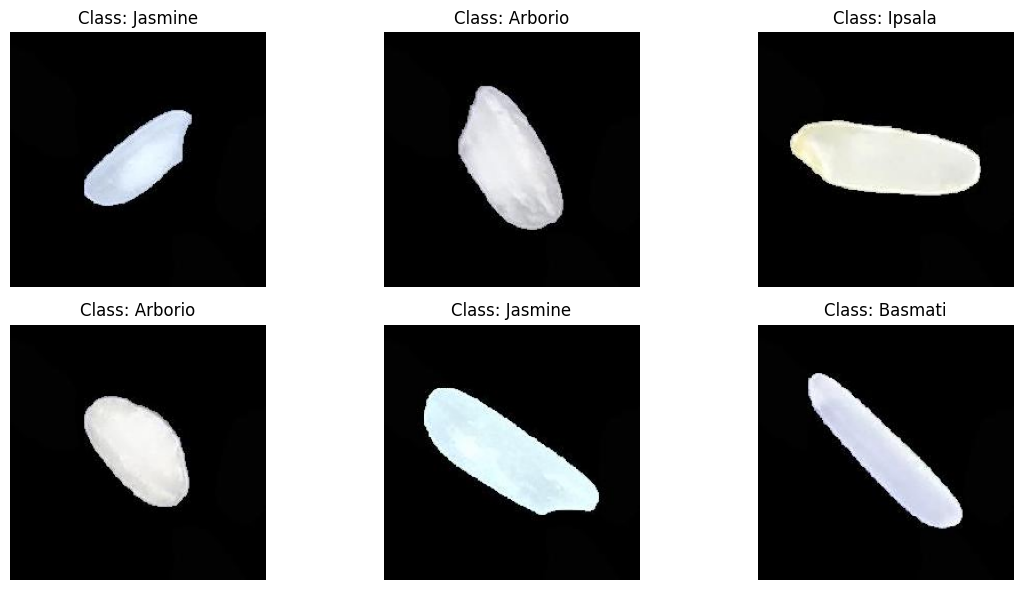

In [4]:
# 2.5.Preview of Images
# Preview 6 sample images from the training generator
images, labels = next(iter(train_generator))
class_names = list(train_generator.class_indices.keys())

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    plt.title(f"Class: {class_names[label_index]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load base model without classifier layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model


In [14]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [8]:
epochs = 10

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)


Epoch 1/10
1875/1875 [==============================] - 9029s 5s/step - loss: 0.8297 - accuracy: 0.7055 - val_loss: 0.4687 - val_accuracy: 0.8927
Epoch 2/10
1875/1875 [==============================] - 9256s 5s/step - loss: 0.4281 - accuracy: 0.8691 - val_loss: 0.2983 - val_accuracy: 0.9216
Epoch 3/10
1875/1875 [==============================] - 13193s 7s/step - loss: 0.3084 - accuracy: 0.9063 - val_loss: 0.2242 - val_accuracy: 0.9321
Epoch 4/10
1875/1875 [==============================] - 10808s 6s/step - loss: 0.2487 - accuracy: 0.9208 - val_loss: 0.1940 - val_accuracy: 0.9379
Epoch 5/10
1875/1875 [==============================] - 10232s 5s/step - loss: 0.2120 - accuracy: 0.9323 - val_loss: 0.1605 - val_accuracy: 0.9485
Epoch 6/10
1875/1875 [==============================] - 11472s 6s/step - loss: 0.1874 - accuracy: 0.9394 - val_loss: 0.1411 - val_accuracy: 0.9533
Epoch 7/10
1875/1875 [==============================] - 9809s 5s/step - loss: 0.1685 - accuracy: 0.9454 - val_loss: 0.12

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)


Found 11250 images belonging to 5 classes.


In [23]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_accuracy:.2f}")


11250/11250 [==============================] - 1892s 168ms/step - loss: 1.7939 - accuracy: 0.2401
✅ Test Accuracy: 0.24


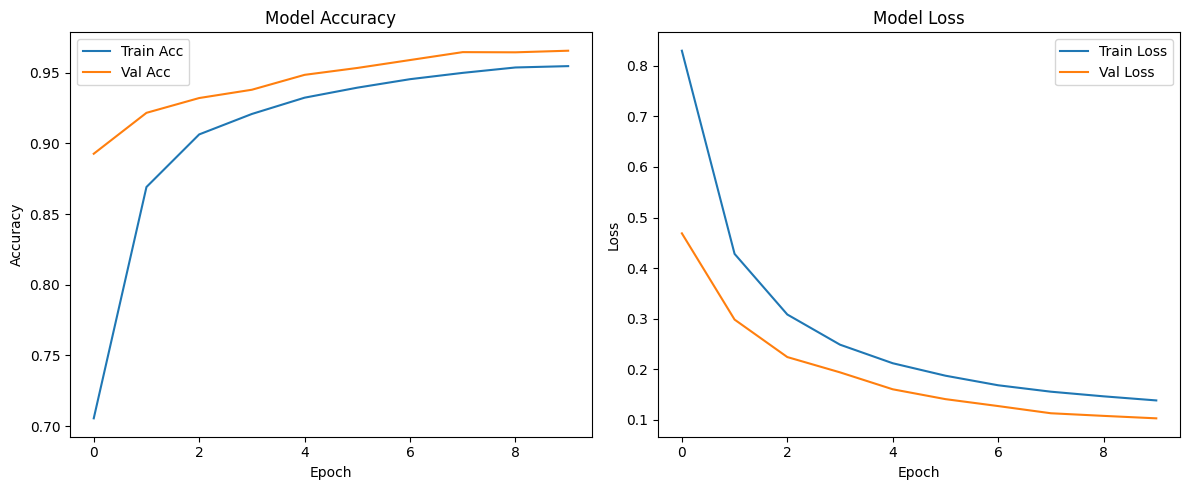

In [24]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [25]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict
test_generator.reset()
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))


11250/11250 [==============================] - 1977s 176ms/step
Classification Report:
              precision    recall  f1-score   support

     Arborio       0.00      0.00      0.00      2250
     Basmati       0.36      0.23      0.28      2250
      Ipsala       0.00      0.00      0.00      2250
     Jasmine       0.22      0.97      0.36      2250
   Karacadag       0.00      0.00      0.00      2250

    accuracy                           0.24     11250
   macro avg       0.12      0.24      0.13     11250
weighted avg       0.12      0.24      0.13     11250



C:\Users\LENOVO\.conda\envs\riceenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\.conda\envs\riceenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\.conda\envs\riceenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
#model.save(r"D:\models\rice_v1.h5")
model.save("rice_classification_model.keras")
#to load
#from tensorflow.keras.models import load_model
#model = load_model("rice_classification_model.keras")